In [1]:
%matplotlib inline
import copy
import qutip
from qutip import Qobj
import numpy as np
import math, cmath
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

from stateobj import Physics
import utilities as use
import circuits as qc

import os

from IPython.display import Markdown, display

In [2]:
TIMESTEPS = 500
TIMEDELTA = 1e-01
OMEGA = 0.5  # Strength of Interaction

D = 30

p = Physics(dimension=D, interaction_strength=OMEGA, interaction_time=TIMEDELTA)

th = OMEGA * TIMEDELTA
alpha = complex(1/math.sqrt(6), 0)
beta = cmath.sqrt(1 - alpha**2)
phi = np.pi/2
# Phase shifts
delta1 = 0
delta2 = -phi

In [3]:
eta = use.create_ancilla_qobj(alpha, beta, phi)
rho1 = use.create_system_qobj('thermal', n=1, n_dims=D)
rho2 = use.create_system_qobj('thermal', n=1, n_dims=D)
rho = qutip.tensor(rho1, rho2)

In [4]:
ga = 2 * alpha ** 2
gb = beta**2 * (1 + np.cos(phi))

In [5]:
def commutator(A: Qobj | np.ndarray, B: Qobj | np.ndarray, kind='regular'):
    if kind == 'regular':
        return A*B - B*A
    elif kind == 'anti':
        return A*B + B*A

def dissipator(X: Qobj | np.ndarray, system: Qobj | np.ndarray, kind='regular'):
    sandwich = X * system * X.dag()
    if kind == 'anti':
        sandwich = X.dag() * system * X
    comm = qutip.commutator(X.dag()*X, system, kind='anti')
    return sandwich - 1/2 * comm

def master_equation(system, ga, gb):
    # Bosonic Operators
    C = p.C
    Cp = p.Cp
    S = p.S
    Sd = p.S.dag()
    first_line = 0.5*dissipator(qutip.tensor(C, C) - 2*qutip.tensor(S, Sd), system)
    first_line += dissipator(qutip.tensor(C, S) + qutip.tensor(S, Cp), system)
    second_line = 0.5*dissipator(qutip.tensor(Cp, Cp) - 2*qutip.tensor(Sd, S), system)
    second_line += dissipator(qutip.tensor(Cp, Sd) + qutip.tensor(Sd, C), system)
    return ga * first_line + gb * second_line

def evolve(system, ga, gb):
    delta_s = master_equation(system, ga, gb)
    return system + delta_s

def hilbert_is_good(system, check):
    """Check if the Hilbert space truncation is still valid"""
    threshold = 9e-4
    if check == 'unitary':
        trace = system.tr()
        return abs(trace - 1) < threshold
    elif check == 'small_tail':
        last_diagonal_element = system.diag()[-1]
        return last_diagonal_element < threshold

In [6]:
entropies = []
purities = []

In [7]:
# Search for file
files = os.listdir('objects/')
t = 0
try:
    # Extract the time from the file name
    time = max([int(f.split('_')[-2][1:]) for f in files if f.startswith('rho_20230707')])
    # Load partial data
    name = f'20230628_t{time}_d{D}'
    rho = qutip.fileio.qload('objects/rho_' + name + '.qu')
    entropies = np.load('objects/entropies_' + name + '.npy').tolist()
    purities = np.load('objects/purities_' + name + '.npy').tolist()
    print(f'Loaded values fot t={time}')
except FileNotFoundError as e:
    # Files not found, run evolution
    print(e)
    for t in trange(TIMESTEPS):
        rho = evolve(rho, ga, gb)
        entropies.append(qutip.entropy_vn(rho))
        purities.append(rho.purity())
    time = t + 1

[Errno 2] No such file or directory: 'objects/rho_20230628_t18000_d30.qu'


100%|██████████| 500/500 [02:00<00:00,  4.14it/s]


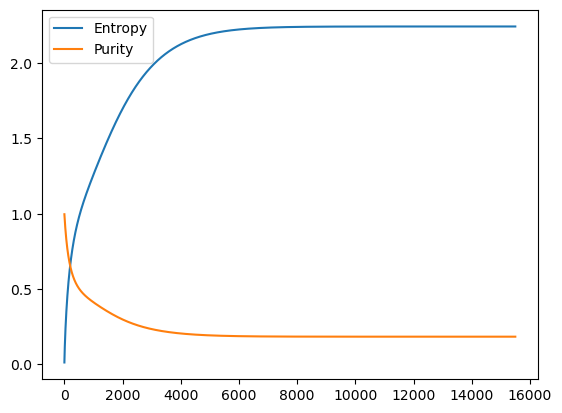

In [17]:
# Plot quantities
plt.plot(entropies, label='Entropy')
plt.plot(purities, label='Purity')
plt.legend()
plt.show()

In [16]:
# Evolve again
for t in trange(10 * TIMESTEPS):
    rho = evolve(rho, ga, gb)
    entropies.append(qutip.entropy_vn(rho))
    purities.append(rho.purity())
time += t + 1

100%|██████████| 5000/5000 [21:16<00:00,  3.92it/s]


In [18]:
time

15500

In [19]:
# Save partial data
name = f'20230707_t{time}_d{D}'
qutip.fileio.qsave(rho, 'objects/rho_' + name + '.qu')
np.save('objects/entropies_' + name + '.npy', np.array(entropies))
np.save('objects/purities_' + name + '.npy', np.array(purities))

In [20]:
rho

Quantum object: dims = [[30, 30], [30, 30]], shape = (900, 900), type = oper, isherm = False
Qobj data =
[[ 3.59999699e-01 -2.46731634e-04  1.45297085e-07 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.46730829e-04  1.43999925e-01 -1.39697250e-04 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.46014947e-07 -1.39696670e-04  5.75999919e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]